In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from photoz_utils import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
photoz = pd.read_csv('/mnt/data/HSC/HSC_v6/HSC_v6.csv')
photoz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286401 entries, 0 to 286400
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   object_id               286401 non-null  int64  
 1   specz_redshift_err      286401 non-null  float64
 2   specz_redshift          286401 non-null  float64
 3   specz_mag_i             286401 non-null  float64
 4   specz_name              286401 non-null  object 
 5   specz_ra                286401 non-null  float64
 6   specz_dec               286401 non-null  float64
 7   specz_flag_homogeneous  286401 non-null  bool   
 8   ra                      286401 non-null  float64
 9   dec                     286401 non-null  float64
 10  coord                   286401 non-null  object 
 11  skymap_id               286401 non-null  int64  
 12  g_cmodel_mag            286401 non-null  float64
 13  r_cmodel_mag            286401 non-null  float64
 14  i_cmodel_mag        

array([[<AxesSubplot:title={'center':'object_id'}>,
        <AxesSubplot:title={'center':'specz_redshift_err'}>,
        <AxesSubplot:title={'center':'specz_redshift'}>,
        <AxesSubplot:title={'center':'specz_mag_i'}>],
       [<AxesSubplot:title={'center':'specz_ra'}>,
        <AxesSubplot:title={'center':'specz_dec'}>,
        <AxesSubplot:title={'center':'ra'}>,
        <AxesSubplot:title={'center':'dec'}>],
       [<AxesSubplot:title={'center':'skymap_id'}>,
        <AxesSubplot:title={'center':'g_cmodel_mag'}>,
        <AxesSubplot:title={'center':'r_cmodel_mag'}>,
        <AxesSubplot:title={'center':'i_cmodel_mag'}>],
       [<AxesSubplot:title={'center':'z_cmodel_mag'}>,
        <AxesSubplot:title={'center':'y_cmodel_mag'}>,
        <AxesSubplot:title={'center':'g_cmodel_magsigma'}>,
        <AxesSubplot:title={'center':'r_cmodel_magsigma'}>],
       [<AxesSubplot:title={'center':'i_cmodel_magsigma'}>,
        <AxesSubplot:title={'center':'z_cmodel_magsigma'}>,
        <Ax

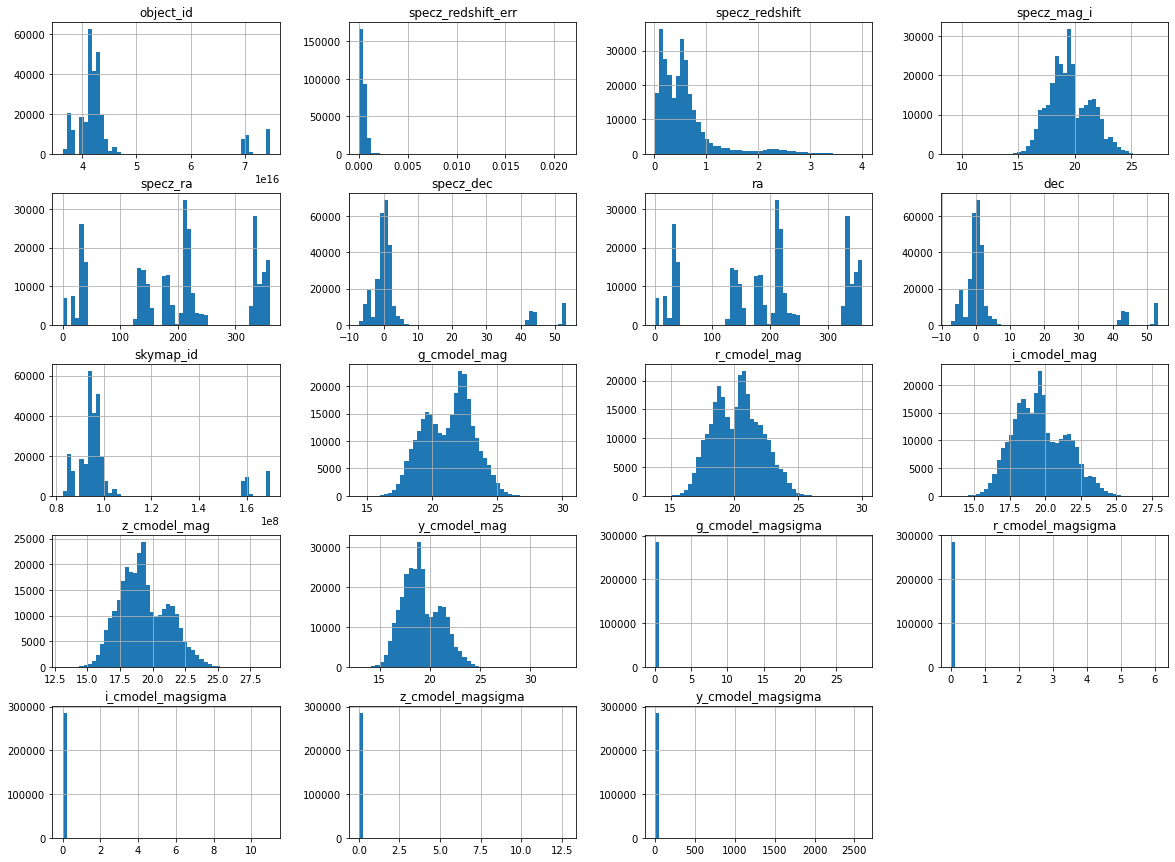

In [5]:
photoz.hist(bins=50, figsize=(20, 15))

In [6]:
photoz = photoz[['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag', 'specz_redshift']]

<AxesSubplot:>

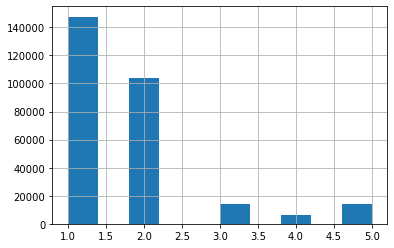

In [7]:

photoz['specz_cat'] = pd.cut(photoz['specz_redshift'], bins=[0, 0.5, 1, 1.5, 2, np.inf], labels=[1, 2, 3, 4, 5])
photoz['specz_cat'].hist() # we'll go with these strata for now

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
for train_index, test_index in split.split(photoz, photoz['specz_cat']):
    strat_train_set = photoz.loc[train_index]
    strat_test_set = photoz.loc[test_index]

In [9]:
strat_train_set['specz_cat'].value_counts() / len(strat_train_set)
# here we see that the proportions are the same

1    0.515302
2    0.363102
3    0.050240
5    0.048979
4    0.022377
Name: specz_cat, dtype: float64

<AxesSubplot:>

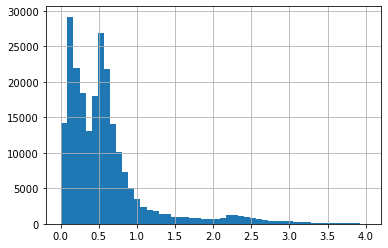

In [10]:
strat_train_set['specz_redshift'].hist(bins=50)

In [11]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("specz_cat", axis=1, inplace=True)
# dropping 'specz_cat'

In [12]:
X_train = strat_train_set.drop('specz_redshift', axis=1)
y_train = strat_train_set['specz_redshift'].copy()
X_test = strat_test_set.drop('specz_redshift', axis=1)
y_test = strat_test_set['specz_redshift'].copy()

In [13]:
# scaling
scaler = StandardScaler()
scaler.fit(X_train)
#print(scaler.mean_)
X_train_tr = scaler.transform(X_train)
# convert back to DataFrame
X_train = pd.DataFrame(data=X_train_tr, columns=X_train.columns, index=X_train.index)

In [14]:
# rand forest model
rand_forest_model = RandomForestRegressor(n_estimators=200)
rand_forest_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

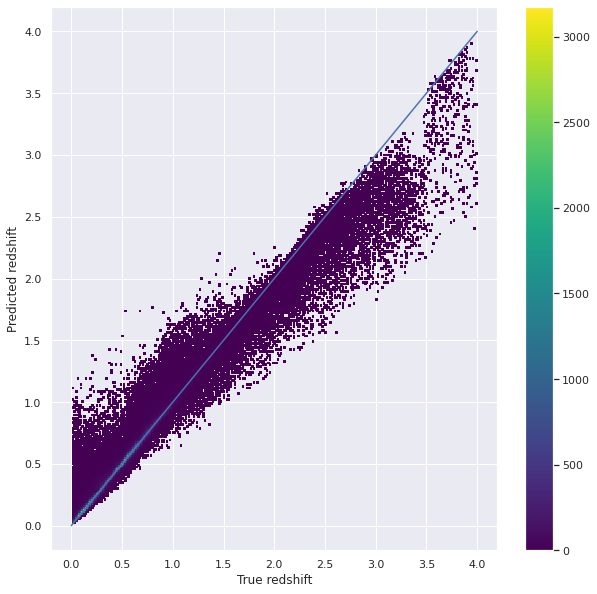

In [15]:
y_train_pred = rand_forest_model.predict(X_train)
y_train_pred = pd.Series(y_train_pred, index=y_train.index)
plot_predictions(y_train_pred, y_train)

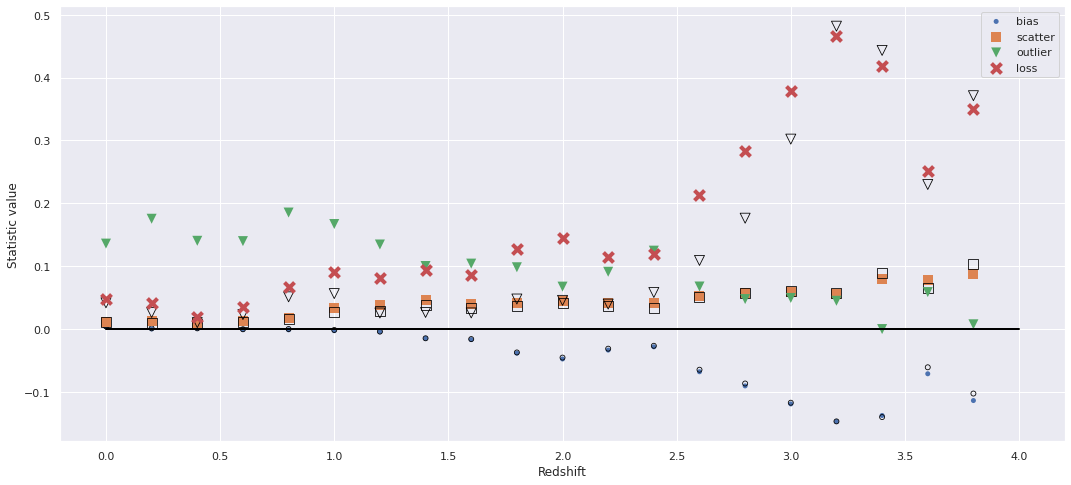

In [16]:
metrics_agg = get_point_metrics(y_train_pred, y_train)
metrics_binned = get_point_metrics(y_train_pred, y_train, binned=True)
plot_point_metrics(metrics_binned)

In [17]:
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
print(f'Train MSE: {train_mse}')
print(f'Average loss: {np.mean(calculate_loss(y_train_pred, y_train))}')
print(f'Bias: {calculate_bias(y_train_pred, y_train)}')
print(f'Scatter: {calculate_scatter(y_train_pred, y_train)}')
print(f'Outlier Rate: {calculate_outlier_rate(y_train_pred, y_train)}')

Train MSE: 0.01227402073581801
Average loss: 0.04895775762249643
Bias: 0.0005807980471356619
Scatter: 0.013854239471291245
Outlier Rate: 0.17731319832402234


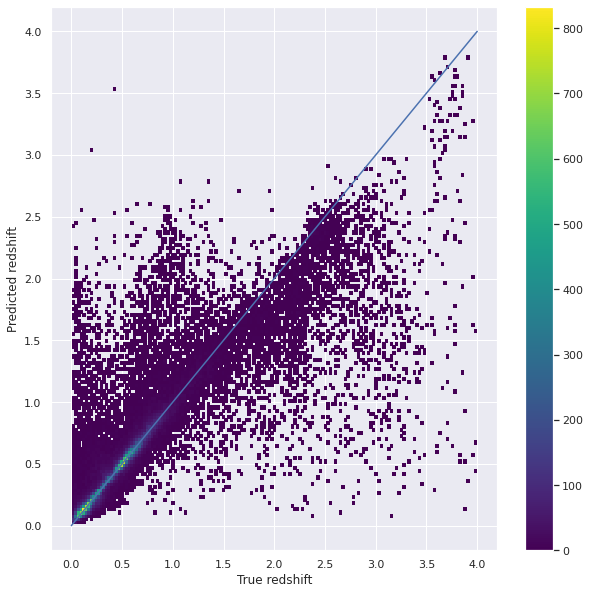

In [18]:
X_test = scaler.transform(X_test)
y_test_pred = rand_forest_model.predict(X_test)
y_test_pred = pd.Series(y_test_pred, index=y_test.index)
plot_predictions(y_test_pred, y_test)

In [19]:
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print(f'Test MSE: {test_mse}')
print(f'Average loss: {np.mean(calculate_loss(y_test_pred, y_test))}')
print(f'Bias: {calculate_bias(y_test_pred, y_test)}')
print(f'Scatter: {calculate_scatter(y_test_pred, y_test)}')
print(f'Outlier Rate: {calculate_outlier_rate(y_test_pred, y_test)}')

Test MSE: 0.08795746454273275
Average loss: 0.1273332768085924
Bias: 0.001528182808345897
Scatter: 0.0374622291235395
Outlier Rate: 0.17808697473856952


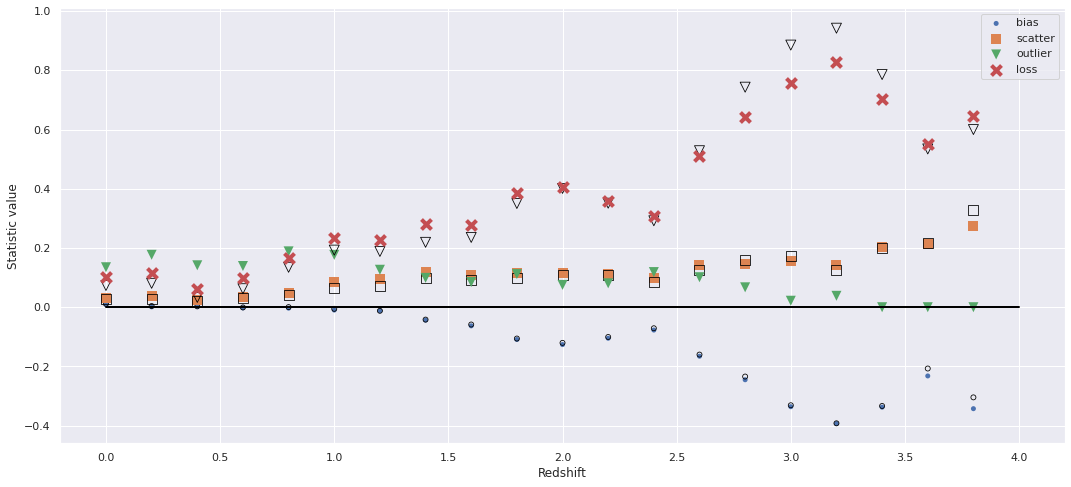

In [21]:
metrics_agg = get_point_metrics(y_test_pred, y_test)
metrics_binned = get_point_metrics(y_test_pred, y_test, binned=True)
plot_point_metrics(metrics_binned)